### Initializing pymc3

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import math
from pymc3 import sample_ppc
from pymc3.plots import plot_posterior
from scipy.stats import multivariate_normal, poisson, norm, invgamma
from seaborn import kdeplot

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


/home/saivikas/anaconda3/envs/vikas/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Specifying training data

In [2]:
#X Data
trt = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

base = np.array([11, 11, 6, 8, 66, 27, 12, 52, 23, 10, 52, 33, 18,
                 42, 87, 50, 18, 111, 18, 20, 12, 9, 17, 28, 55, 9, 10, 47, 76, 38, 19, 10,
                 19, 24, 31, 14, 11, 67, 41, 7, 22, 13, 46, 36, 38, 7, 36, 11, 151, 22, 41,
                 32, 56, 24, 16, 22, 25, 13, 12])
age = np.array([31, 30, 25, 36, 22, 29, 31, 42, 37, 28, 36, 24, 23,
                36, 26, 26, 28, 31, 32,21, 29, 21, 32, 25, 30, 40,
                19, 22, 18, 32, 20, 30, 18, 24, 30, 35, 27, 20,22,
                28, 23, 40, 33, 21, 35, 25, 26, 25, 22, 32, 25,35, 21, 41, 32, 26, 21, 36, 37])

v4 = np.array([0,0,0,1])

#Y data
y = np.array([[5,3,3,3],[3,5,3,3],[2,4,0,5],[4,4,1,4],[7,18,9,21],[5,2,8,7],[6,4,0,2],[40,20,21,12],[5,6,6,5],
   [14,13,6,0],[26,12,6,22],[12,6,8,4],[4,4,6,2],[7,9,12,14],[16,24,10,9],[11,0,0,5],[0,0,3,3],[37,29,28,29],
   [3,5,2,5],[3,0,6,7],[3,4,3,4],[3,4,3,4],[2,3,3,5],[8,12,2,8],[18,24,76,25],[2,1,2,1],[3,1,4,2],
   [13,15,13,12],[11,14,9,8],[8,7,9,4],[0,4,3,0],[3,6,1,3],[2,6,7,4],[4,3,1,3],[22,17,19,16],
   [5,4,7,4],[2,4,0,4],[3,7,7,7],[4,18,2,5],[2,1,1,0],[0,2,4,0],[5,4,0,3],[11,14,25,15],[10,5,3,8],
   [19,7,6,7],[1,1,2,3],[6,10,8,8],[2,1,0,0],[102,65,72,63],[4,3,2,4],[8,6,5,7],[1,3,1,5],[18,11,28,13],
   [6,3,4,0],[3,5,4,3],[1,23,19,8],[2,3,0,1],[0,0,0,0],[1,4,3,2]])

data_size = len(age)
days = 4

### Preprocessing

In [3]:
#augment data to have same dimensions
trt = trt.reshape(-1,1)
trt = np.tile(trt,(1,4))

base = base.reshape(-1,1)
base = np.tile(base,(1,4))

age = age.reshape(-1,1)
age = np.tile(age,(1,4))

v4 = v4.reshape(-1,1)
v4 = np.tile(v4,(1,59)).T

print(trt.shape,base.shape,age.shape,v4.shape)

(59, 4) (59, 4) (59, 4) (59, 4)


### Specifying the model

In [26]:
#Creating the model

model = pm.Model()

with model:
    #priors
    
    var_b  = pm.InverseGamma('var_b',1,1)
    var_b1 = pm.InverseGamma('var_b1',1,1)
    
    a_base = pm.Normal('alpha_base',mu=0,sd=100)
    a_trt = pm.Normal('alpha_trt',mu=0,sd=100)
    a_bt = pm.Normal('alpha_bt',mu=0,sd=100)
    a_age = pm.Normal('alpha_age',mu=0,sd=100)
    a_v4 = pm.Normal('alpha_v4',mu=0,sd=100)
    a_not = pm.Normal('alpha_not',mu=0,sd=100)
    
    b1 = pm.Normal('b1',mu=0,sd=np.sqrt(var_b1))
    b = pm.Normal('b',mu=0,sd=np.sqrt(var_b))
    
    #expected value of parameter mu
   # log_mu = a_not + (a_base * np.log(base/4)) + (a_trt * trt) + (a_bt * trt * np.log(base/4)) \
   #             + (a_age * np.log(age)) + b1
    log_mu = a_not + (a_v4*v4) + (a_base * np.log(base/4)) + (a_trt * trt) + (a_bt * trt * np.log(base/4)) + (a_age * np.log(age)) + b1 + b

    mu = np.exp(log_mu)
    #likelihood
    Y_obs = pm.Poisson('Y_obs',mu,observed=y)

### Run ADVI

In [27]:
#get the posterior 
with model:
    mean_field = pm.fit(method='advi')

Average Loss = 4,097.7: 100%|██████████| 10000/10000 [00:05<00:00, 1937.88it/s]
Finished [100%]: Average Loss = 4,140.4


### Plotting Results

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha_base,0.323675,0.305502,0.009921,-0.304276,0.905565
alpha_trt,-0.090859,0.455816,0.014961,-1.041975,0.739327
alpha_bt,0.133292,0.320609,0.010968,-0.518703,0.721901
alpha_age,0.108354,0.244549,0.007587,-0.330833,0.586117
alpha_v4,-0.096413,0.437060,0.013658,-0.893543,0.787229
alpha_not,0.093945,0.441775,0.013790,-0.801888,0.931559
b1,0.097796,0.433958,0.013271,-0.794113,0.880270
b,0.072636,0.451135,0.013110,-0.864146,0.931255
var_b,1.409477,1.482323,0.047821,0.074588,4.250072
var_b1,1.346682,1.639765,0.055703,0.069189,3.747757


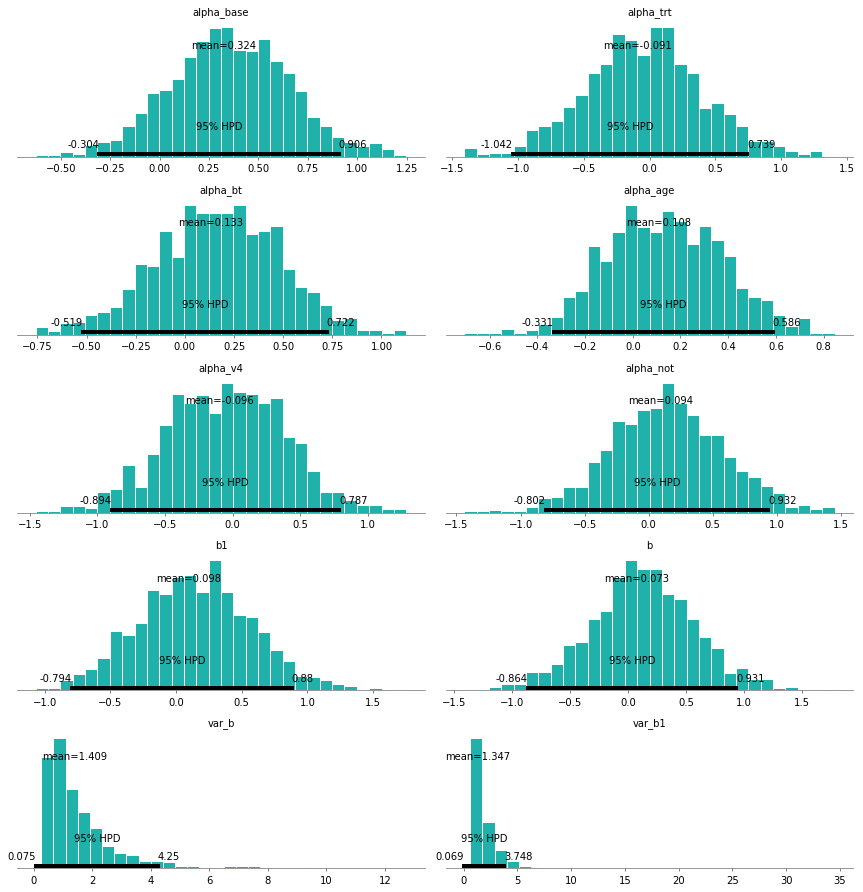

In [28]:
trace = mean_field.sample(1000)
pm.plot_posterior(trace,color='LightSeaGreen')
pm.summary(trace)

### Making Predictions

In [29]:
ppc = sample_ppc(trace, model=model, samples=100)

100%|██████████| 100/100 [00:00<00:00, 895.42it/s]


In [30]:
predictions = ppc['Y_obs']

#get the mean and variance of the predictions
mean_preds = np.mean(predictions,axis=0)
var_preds =  np.var(predictions,axis=0)

mse_loss = np.sum((y - mean_preds) ** 2) / (59 * 4.0)

print('MSE loss: ',mse_loss)
print('True Values: ',y)
print('Mean predictions: ',mean_preds)
print('Variance of predictions: ',var_preds)

MSE loss:  81.35377457627118
True Values:  [[  5   3   3   3]
 [  3   5   3   3]
 [  2   4   0   5]
 [  4   4   1   4]
 [  7  18   9  21]
 [  5   2   8   7]
 [  6   4   0   2]
 [ 40  20  21  12]
 [  5   6   6   5]
 [ 14  13   6   0]
 [ 26  12   6  22]
 [ 12   6   8   4]
 [  4   4   6   2]
 [  7   9  12  14]
 [ 16  24  10   9]
 [ 11   0   0   5]
 [  0   0   3   3]
 [ 37  29  28  29]
 [  3   5   2   5]
 [  3   0   6   7]
 [  3   4   3   4]
 [  3   4   3   4]
 [  2   3   3   5]
 [  8  12   2   8]
 [ 18  24  76  25]
 [  2   1   2   1]
 [  3   1   4   2]
 [ 13  15  13  12]
 [ 11  14   9   8]
 [  8   7   9   4]
 [  0   4   3   0]
 [  3   6   1   3]
 [  2   6   7   4]
 [  4   3   1   3]
 [ 22  17  19  16]
 [  5   4   7   4]
 [  2   4   0   4]
 [  3   7   7   7]
 [  4  18   2   5]
 [  2   1   1   0]
 [  0   2   4   0]
 [  5   4   0   3]
 [ 11  14  25  15]
 [ 10   5   3   8]
 [ 19   7   6   7]
 [  1   1   2   3]
 [  6  10   8   8]
 [  2   1   0   0]
 [102  65  72  63]
 [  4   3   2   4]
 [  8  

## Own Implementation

In [348]:
def find_loglikelihood(theta):
    
    a_not = theta[0]
    a_base = theta[1]
    a_trt = theta[2]
    a_bt = theta[3]
    a_age = theta[4]
    a_v4 = theta[5]
    var_b1 = abs(theta[6])
    var_b = abs(theta[7])
    
    b1 = norm.rvs(0,np.sqrt(var_b1),size=1)
    b = norm.rvs(0,np.sqrt(var_b),size=1)
    
    log_mu = a_not + (a_v4*v4) + (a_base* np.log(base/4)) + (a_trt * trt) + (a_bt * trt * np.log(base/4)) + (a_age * np.log(age)) + b1 + b
    mu = np.exp(log_mu)
    
    mu = mu.flatten()
    ypred = y.flatten()
    
    #print(mu,ypred)
    
    
    likelihood  = poisson(mu).pmf(ypred)
    
    likelihood[likelihood == 0] = 1e-10
    
    log_l = np.log(likelihood).sum()
    
    return log_l

def find_logprior(theta,prior_params):
    
    a_not = theta[0]
    a_base = theta[1]
    a_trt = theta[2]
    a_bt = theta[3]
    a_age = theta[4]
    a_v4 = theta[5]
    var_b1 = theta[6]
    var_b = theta[7]
    
    prior_anot = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_not)
    prior_abase = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_base)
    prior_atrt = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_trt)
    prior_abt = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_bt)
    prior_age = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_age)
    prior_av4 = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_v4)
    
    prior_varb1 = invgamma(a=prior_params['var_b'],scale=prior_params['var_b']).pdf(var_b1)
    prior_varb = invgamma(a=prior_params['var_b'],scale=prior_params['var_b']).pdf(var_b)
    
    cumulative_log_prior = np.log(prior_anot) + np.log(prior_abase) +  np.log(prior_atrt) + np.log(prior_abt) + \
            np.log(prior_age) + np.log(prior_av4) + np.log(prior_varb) + np.log(prior_varb1)
    #print(prior_b,prior_b1)
    return cumulative_log_prior

In [349]:
def find_likelihood(theta):
    
    a_not = theta[0]
    a_base = theta[1]
    a_trt = theta[2]
    a_bt = theta[3]
    a_age = theta[4]
    a_v4 = theta[5]
    var_b1 = abs(theta[6])
    var_b = abs(theta[7])
    
    b1 = norm.rvs(0,np.sqrt(var_b1),size=1)
    b = norm.rvs(0,np.sqrt(var_b),size=1)
    
    log_mu = a_not + (a_v4*v4) + (a_base* np.log(base/4)) + (a_trt * trt) + (a_bt * trt * np.log(base/4)) + (a_age * np.log(age)) + b1 + b
    mu = np.exp(log_mu)
    
    mu = mu.flatten()
    ypred = y.flatten()
    
    #print(mu,ypred)
    
    
    likelihood  = poisson(mu).pmf(ypred)
    
    likelihood[likelihood == 0] = 1e-10
    
    likelihood = likelihood.prod()
    
    return likelihood

def find_prior(theta,prior_params):
    
    a_not = theta[0]
    a_base = theta[1]
    a_trt = theta[2]
    a_bt = theta[3]
    a_age = theta[4]
    a_v4 = theta[5]
    var_b1 = theta[6]
    var_b = theta[7]
    
    prior_anot = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_not)
    prior_abase = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_base)
    prior_atrt = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_trt)
    prior_abt = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_bt)
    prior_age = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_age)
    prior_av4 = norm(prior_params['a_mu'],prior_params['a_sd']).pdf(a_v4)
    
    prior_varb1 = invgamma(a=prior_params['var_b'],scale=prior_params['var_b']).pdf(var_b1)
    prior_varb = invgamma(a=prior_params['var_b'],scale=prior_params['var_b']).pdf(var_b)
    
    cumulative_prior = prior_anot * prior_abase * prior_atrt * prior_abt * \
            prior_age * prior_av4 * prior_varb * prior_varb1
    #print(prior_b,prior_b1)
    return cumulative_prior
    
    

In [350]:
def tune(scale, acc_rate):
    # Switch statement
    if acc_rate < 0.001:
        # reduce by 90 percent
        scale *= 0.1
    elif acc_rate < 0.05:
        # reduce by 50 percent
        scale *= 0.5
    elif acc_rate < 0.2:
        # reduce by ten percent
        scale *= 0.9
    elif acc_rate > 0.95:
        # increase by factor of ten
        scale *= 10.0
    elif acc_rate > 0.75:
        # increase by double
        scale *= 2
    elif acc_rate > 0.5:
        # increase by ten percent
        scale *= 1.1

    return scale

In [351]:
def mcmc_mh_log(prior_params,samples=10,interval=10,proposal_width=0.1):
    
    #initial parameters
    #in this order : a_not,a_base,a_trt,a_bt,a_age,a_v4,b1,b,var_b1,var_b
    theta_current = np.ones(8)
    #print(theta_current)
    posterior = [theta_current]
    
    
    accepted = 0
    
    interval_size = interval
    
    for i in range(samples-1):
        
        if i % interval_size == 0:
            proposal_width = tune(proposal_width,accepted/float(interval_size))
            accepted = 0
        
        #proposal parameters
        theta_proposal = multivariate_normal(mean=theta_current,cov=proposal_width).rvs()

        #find likelihoods
        ll_current = find_loglikelihood(theta_current)
        ll_proposal = find_loglikelihood(theta_proposal)
        
        #prior probability of current and proposed
        lp_current = find_logprior(theta_current,prior_params)
        lp_proposal = find_logprior(theta_proposal,prior_params)
        
        logp_accept = ll_proposal + lp_proposal - (ll_current + lp_current)
    
        accept = np.exp(logp_accept)
                
        accept = np.random.rand() < logp_accept
        
        if accept: 
            theta_current = theta_proposal
            accepted += 1
            
        posterior.append(theta_current)
        
        
    posterior = np.array(posterior)    
    return posterior

In [359]:
def mcmc_mh(prior_params,samples=10,interval=10,proposal_width=1):
    
    #initial parameters
    #in this order : a_not,a_base,a_trt,a_bt,a_age,a_v4,b1,b,var_b1,var_b
    theta_current = np.ones(8)
    #print(theta_current)
    posterior = [theta_current]
    
    
    accepted = 0
    
    interval_size = interval
    
    for i in range(samples-1):
        
        if i % interval_size == 0:
            proposal_width = tune(proposal_width,accepted/float(interval_size))
            accepted = 0
        
        #proposal parameters
        theta_proposal = multivariate_normal(mean=theta_current,cov=proposal_width).rvs()

        #find likelihoods
        likelihood_current = find_likelihood(theta_current)
        likelihood_proposal = find_likelihood(theta_proposal)
        
        #prior probability of current and proposed
        prior_current = find_prior(theta_current,prior_params)
        prior_proposal = find_prior(theta_proposal,prior_params)
        
        # p(z hat)
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        
        
        p_accept = p_proposal / p_current
        accept = np.random.rand() < p_accept
        
        if accept: 
            theta_current = theta_proposal
            accepted += 1

            
        posterior.append(theta_current)
        
        
    posterior = np.array(posterior)    
    return posterior

In [360]:
prior_params = {
    'a_mu' : 0,
    'a_sd' : 100,
    'var_b' : 1
}

my_trace = mcmc_mh_log(prior_params,interval=100,samples=500)
mean_trace = my_trace.mean(axis=0)
var_trace = my_trace.std(axis=0)


trace_b1 = norm(0,np.sqrt(my_trace[:,6])).rvs()
trace_b =  norm(0,np.sqrt(my_trace[:,7])).rvs()

print(trace_b1.shape,trace_b.shape)

mean_b1 = np.mean(trace_b1)
std_b1 = np.std(trace_b1)
mean_b  = np.mean(trace_b)
std_b = np.std(trace_b)


print('           Mean    SD')
print('alpha_not:   %.3f   %.3f' % (mean_trace[0],var_trace[0]))
print('alpha_base:  %.3f   %.3f' % (mean_trace[1],var_trace[1]))
print('alpha_trt:   %.3f   %.3f' % (mean_trace[2],var_trace[2]))
print('alpha_bt:    %.3f   %.3f' % (mean_trace[3],var_trace[3]))
print('alpha_age:   %.3f   %.3f' % (mean_trace[4],var_trace[4]))
print('alpha_v4:    %.3f   %.3f' % (mean_trace[5],var_trace[5]))
print('var b1:      %.3f   %.3f' % (mean_trace[6],var_trace[6]))
print('var b:       %.3f   %.3f' % (mean_trace[7],var_trace[7]))
print('b:           %.3f   %.3f'  % (mean_b,std_b)  )
print('b1:           %.3f   %.3f'  % (mean_b1,std_b1)  )

(500,) (500,)
           Mean    SD
alpha_not:   -0.162   0.735
alpha_base:  0.988   0.394
alpha_trt:   0.958   0.301
alpha_bt:    1.361   0.708
alpha_age:   -0.798   0.521
alpha_v4:    1.264   0.235
var b1:      1.167   0.419
var b:       0.852   0.378
b:           0.074   0.936
b1:           0.076   1.069


In [361]:
def plot(trace):
    f, axarr = plt.subplots(len(trace.keys()), 2,figsize=(15,30))
    for i,key in enumerate(trace.keys()):
        values = trace[key]
        kdeplot(values, ax=axarr[i,0])
        axarr[i,0].set_title(key)
        axarr[i,0].set_ylabel('Frequency')
        axarr[i,1].plot(values)
        axarr[i,1].set_title(key)
        axarr[i,1].set_ylabel('Sample value')
        

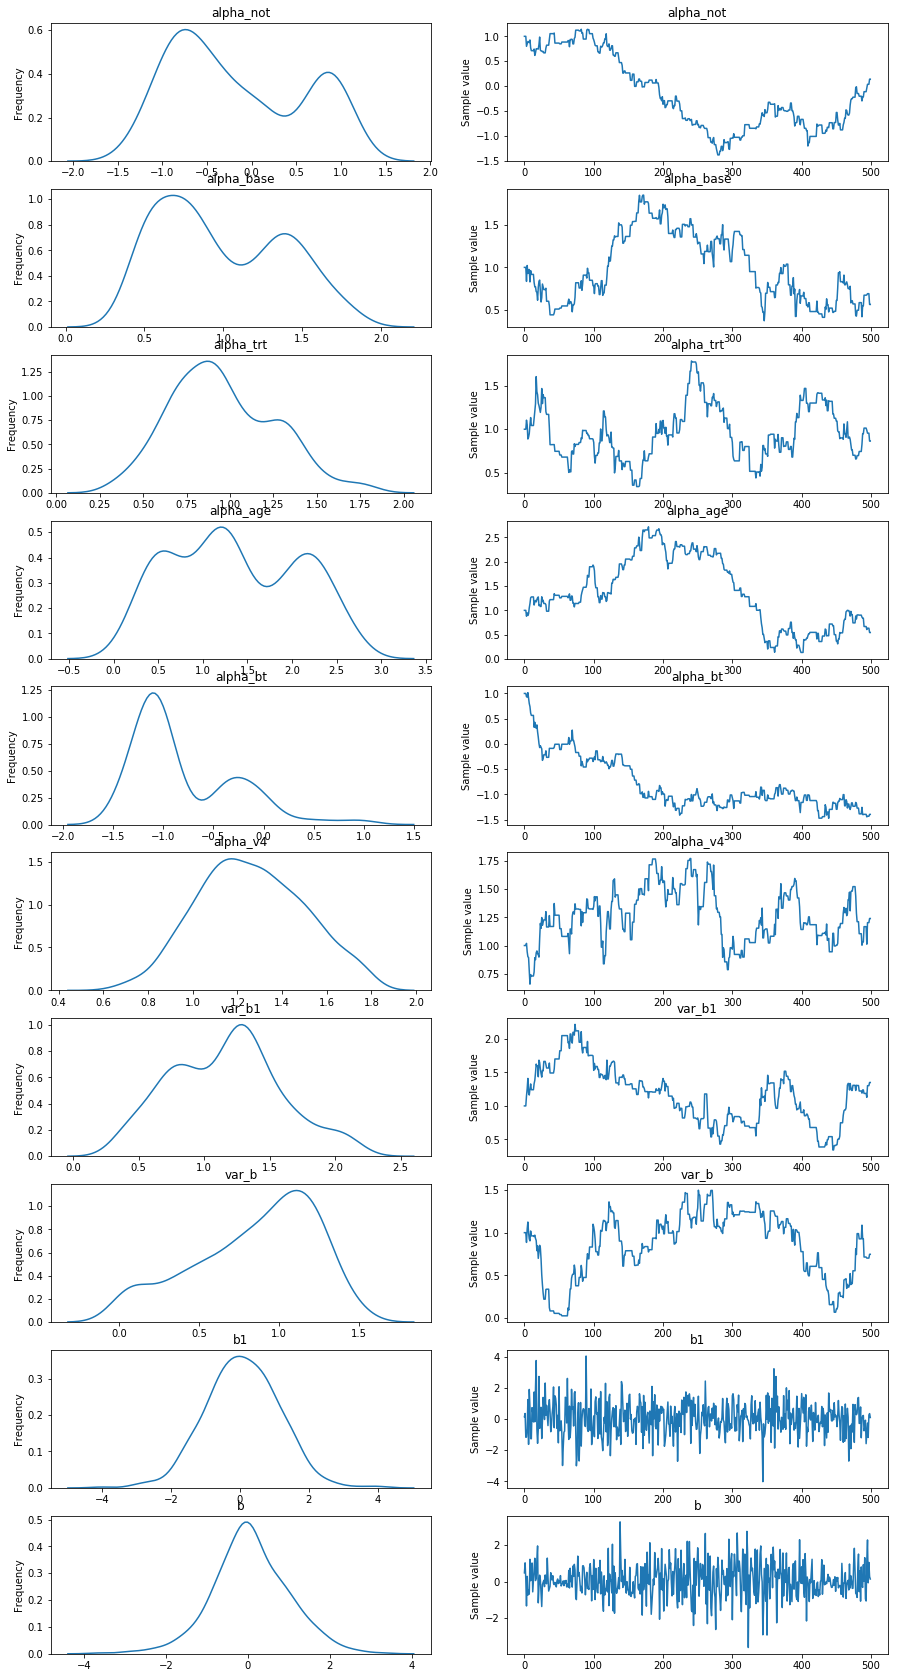

In [362]:
trace_dict = {}
trace_dict['alpha_not'] = my_trace[:,0]
trace_dict['alpha_base'] = my_trace[:,1]
trace_dict['alpha_trt'] = my_trace[:,2]
trace_dict['alpha_age'] = my_trace[:,3]
trace_dict['alpha_bt'] = my_trace[:,4]
trace_dict['alpha_v4'] = my_trace[:,5]
trace_dict['var_b1'] = my_trace[:,6]
trace_dict['var_b'] = my_trace[:,7]
trace_dict['b1'] = trace_b1
trace_dict['b'] = trace_b

plot(trace_dict)

In [366]:
def predict(theta,size):
    a_not = theta[0]
    a_base = theta[1]
    a_trt = theta[2]
    a_bt = theta[3]
    a_age = theta[4]
    a_v4 = theta[5]
    var_b1 = abs(theta[6])
    var_b = abs(theta[7])
    
    b1 = norm.rvs(0,np.sqrt(var_b1),size=1)
    b = norm.rvs(0,np.sqrt(var_b),size=1)
    
    log_mu = a_not + (a_v4*v4) + (a_base* np.log(base/4)) + (a_trt * trt) + (a_bt * trt * np.log(base/4)) + (a_age * np.log(age)) + b1 + b
    
    mu = np.exp(log_mu)
    
    pred = poisson.rvs(mu,size=(size,mu.shape[0],mu.shape[1]))
    return pred

def get_ppc(trace,samples=50,size=100):
    
    #sample parameters from the trace
    trace_len = trace.shape[0]
    rand_indexes = np.random.randint(0,trace_len,size=samples)

    #sampled parameters
    params = trace[rand_indexes]
    
    #predictions 
    predictions = []
    for p in params:
        y = predict(p,size)
        predictions.extend(y)
    
    predictions = np.array(predictions)
    return predictions

In [367]:
preds = get_ppc(my_trace)
preds.shape

(5000, 59, 4)

In [368]:
preds_mean = preds.mean(axis=0)

print('MSE loss: ',  np.sum((y - preds_mean) ** 2) / (59 * 4.0))
preds_mean.astype(int)

MSE loss:  205699158.54483363


array([[     2,      2,      2,      8],
       [     2,      2,      2,      7],
       [     1,      1,      1,      3],
       [     2,      2,      2,      6],
       [    16,     16,     16,     52],
       [     7,      6,      6,     20],
       [     3,      3,      3,      8],
       [    16,     17,     17,     48],
       [     6,      6,      6,     19],
       [     2,      2,      2,      6],
       [    15,     15,     15,     46],
       [     7,      8,      7,     23],
       [     4,      4,      4,     12],
       [    12,     12,     12,     36],
       [    23,     23,     23,     74],
       [    12,     12,     12,     39],
       [     4,      4,      4,     12],
       [    33,     33,     33,    103],
       [     4,      4,      4,     13],
       [     4,      4,      4,     13],
       [     3,      3,      3,      8],
       [     1,      1,      1,      5],
       [     4,      4,      4,     12],
       [     6,      6,      6,     20],
       [    15, 